# To-do

- change attribute types to decrease size

# <center> Credit card fraud </center>

The goal of this project is to apply ML techniques to predict fraud in credit card transactions. A comparison is also made between a traditional solution and one that takes into account concept drift in the data.

**Dataset information**:  
Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.
- 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset
- 'Amount' is the transaction Amount
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise

# Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit

from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Get Data

In [2]:
# load data
df = pd.read_csv('./creditcard_data.csv')

# transform column names
df.columns = df.columns.str.lower()

df

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-null  float64
 21  v21     28

There is no missing data.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
v1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
v2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
v3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
v4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
v5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
v6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
v7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
v8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
v9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


Unfortunately, with no more information on the columns, further feature engineering isn't possible, including transformations from business rules and knowledge. Some example of features that can be included:

**from signifyd**
- IP
- address
- click behavior (amount of clicks, click speed)
- other behavioral data
- purchase history

**new variables**
- period of purchase (morning, afternoon, night)
- day of purchase (weekday, weekend)
- pages/products visited in website (avg amount)
- average purchase amount

# Exploratory Analysis

## Univariate

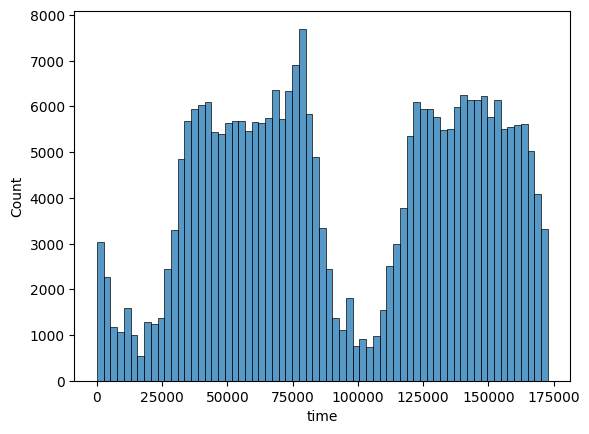

In [5]:
sns.histplot(df['time']);

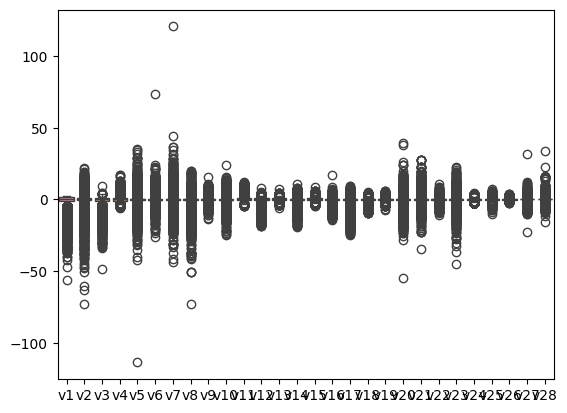

In [6]:
# numeric variables
sns.boxplot(df.iloc[:, 1:-2]);

There is a very heavy presence of outliers in all of the numeric variables, a not so strict method of outlier removal can be applied as to not remove too many instances.

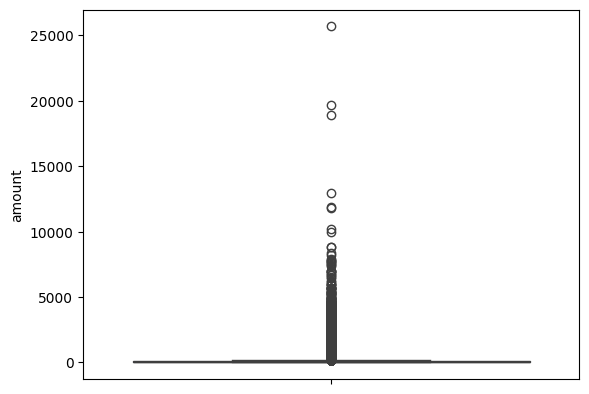

In [7]:
# transaction amount
sns.boxplot(df['amount']);

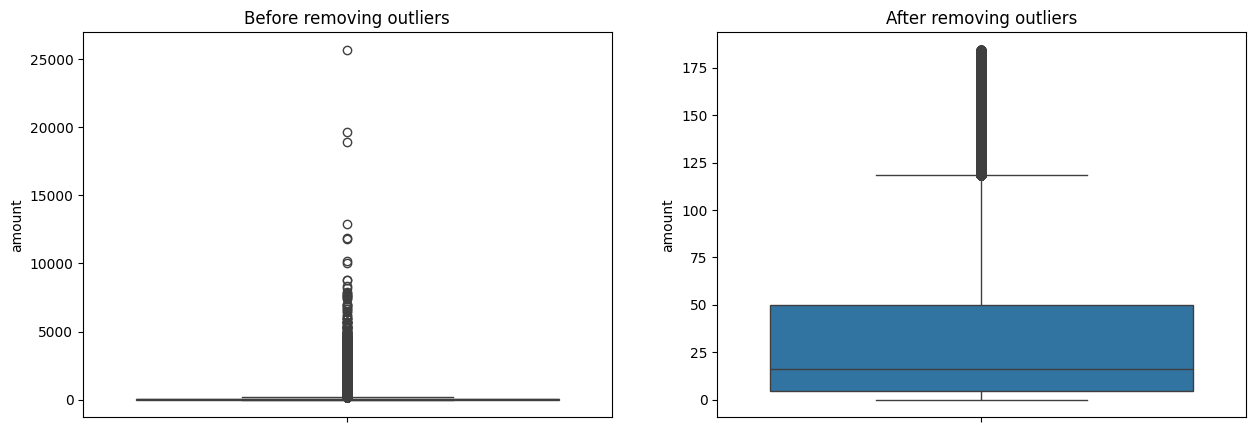

In [8]:
# amount analysis
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(df['amount'], ax=ax[0])
ax[0].set_title('Before removing outliers')

# Remove outliers
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
df_no_outliers = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]

sns.boxplot(data=df_no_outliers['amount'], ax=ax[1])
ax[1].set_title('After removing outliers')
plt.show()


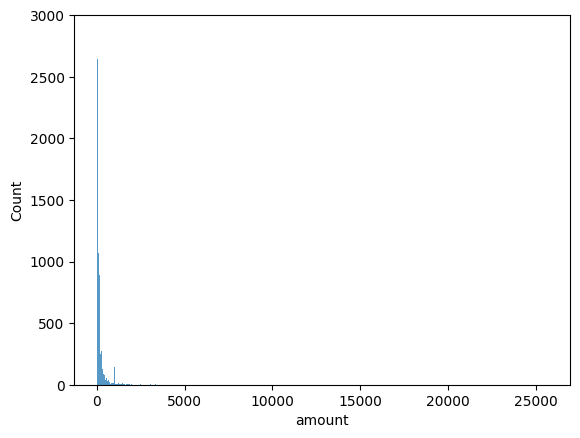

In [9]:
sns.histplot(df['amount'])
plt.ylim(0, 3000);

Most common transactions are of value lower than 25 dollars.

In [10]:
# Target variable, extremely imbalanced
print('Legit:', df[df['class'] == 0.].shape[0], f'({round(df[df["class"] == 0.].shape[0] / df.shape[0], 4)} %)')
print('Fraud:', df[df['class'] == 1.].shape[0], f'({round(df[df["class"] == 1.].shape[0] / df.shape[0], 4)} %)')

Legit: 284315 (0.9983 %)
Fraud: 492 (0.0017 %)


## Bivariate

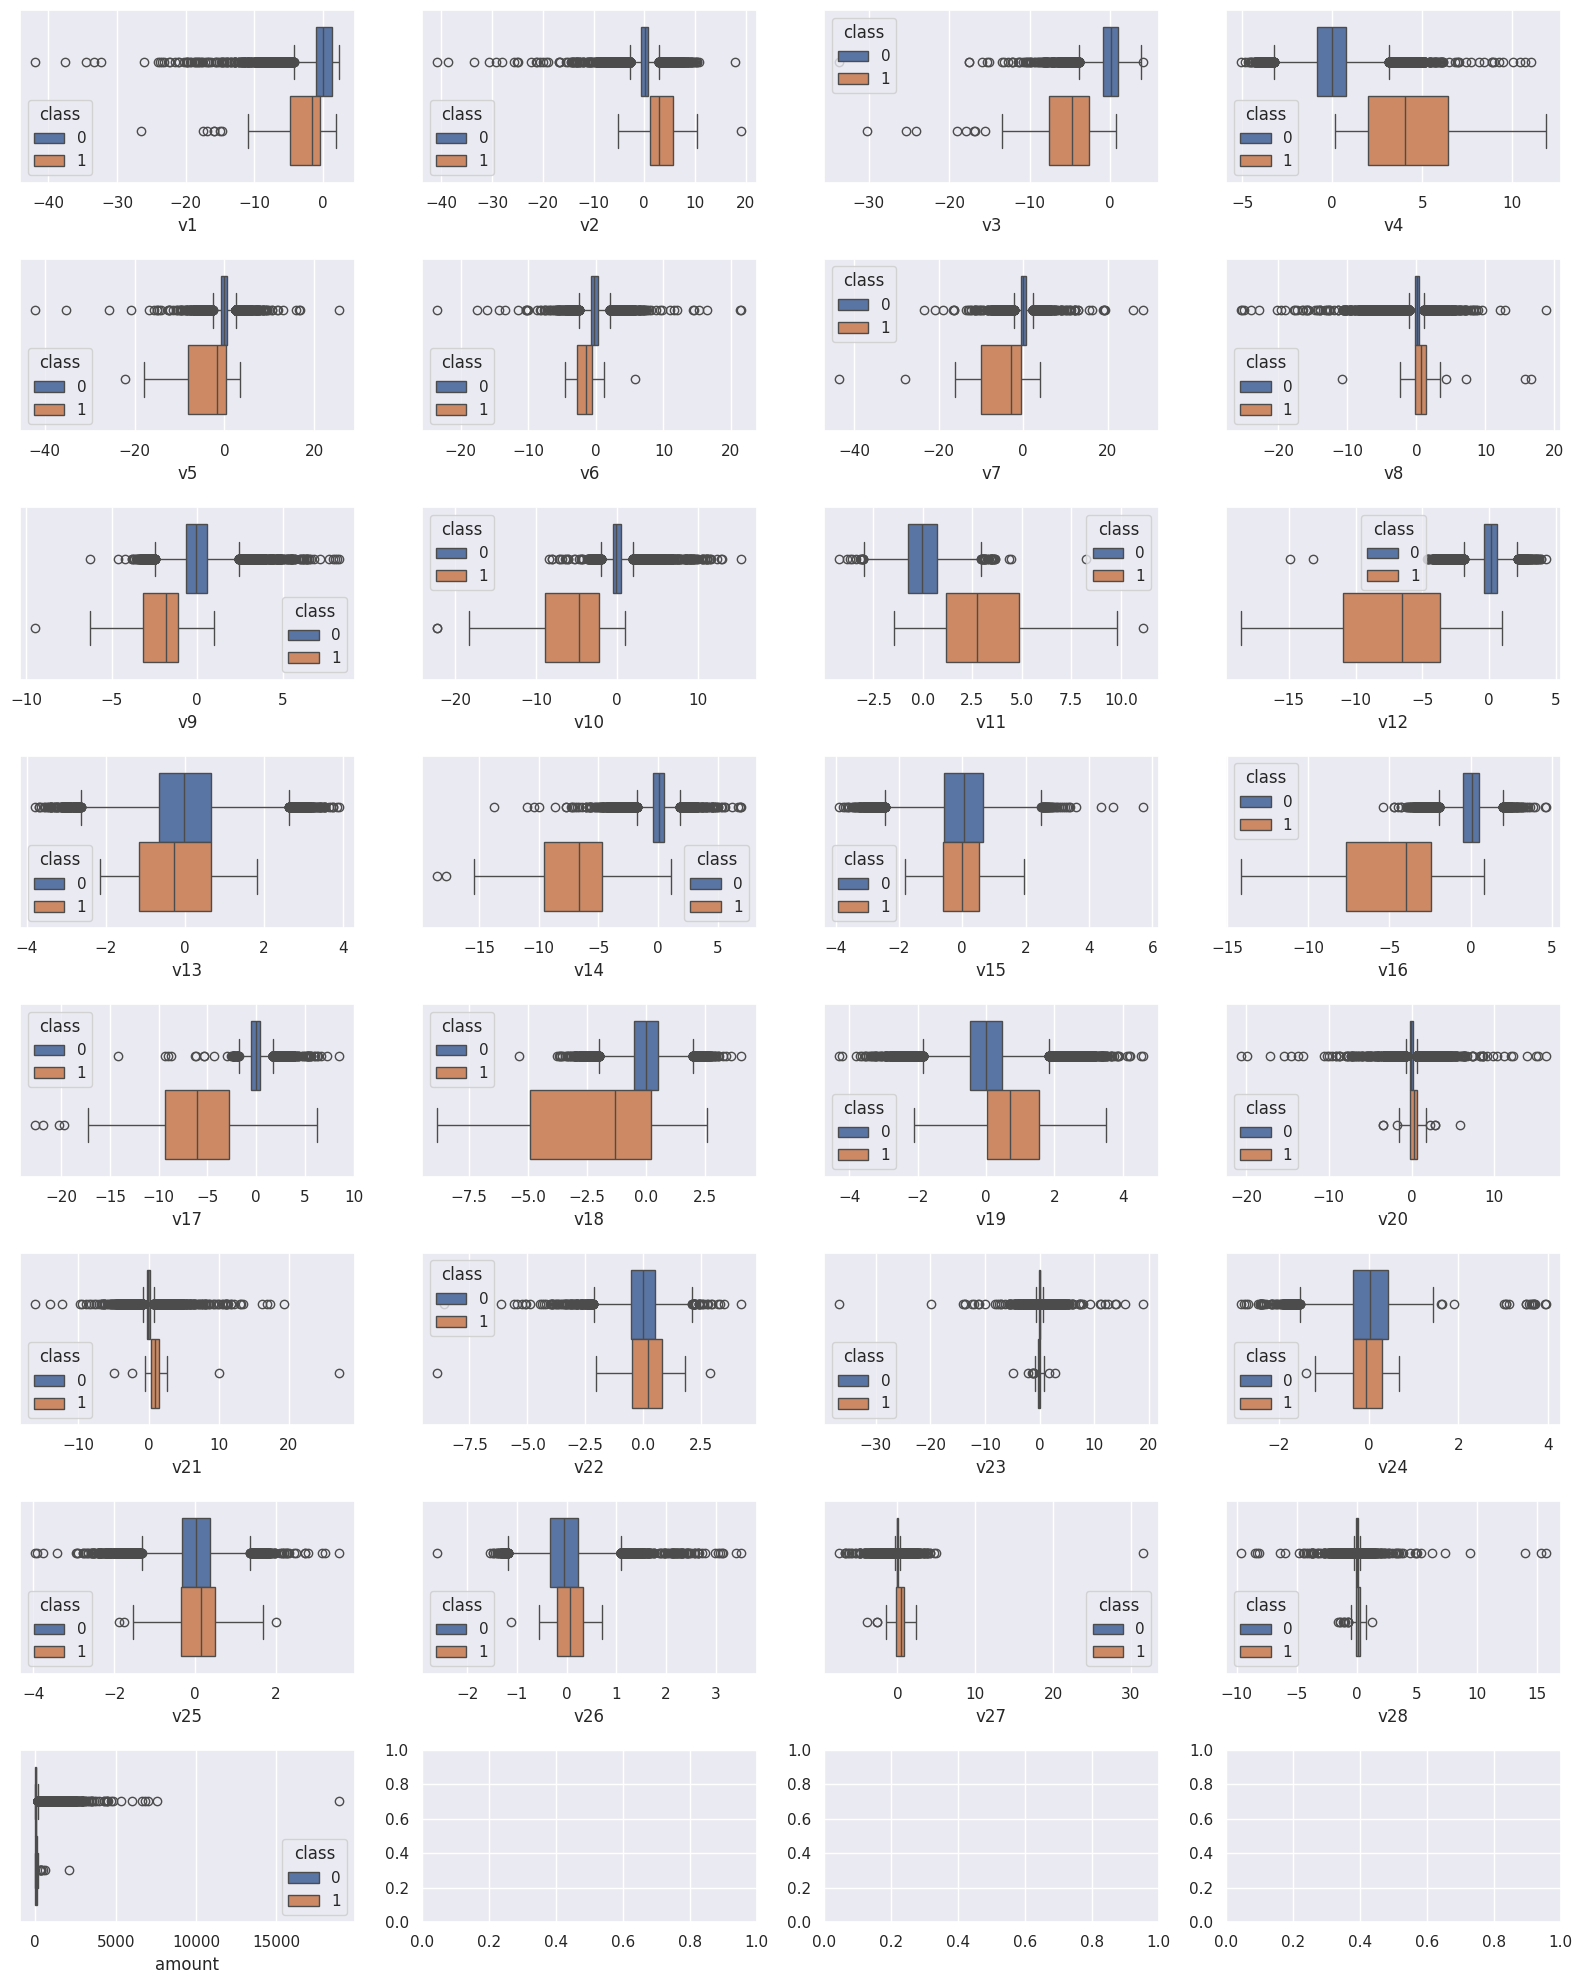

In [11]:
# comparing distributions with 10% of the data
sns.set(style="darkgrid")
fig, axes = plt.subplots(8, 4, figsize=(16, 20))
for i, col in enumerate(df.columns[1:-1]):
    sns.boxplot(data=df.sample(frac=0.1), x=col, hue='class', ax=axes[i // 4, i % 4])
plt.tight_layout()

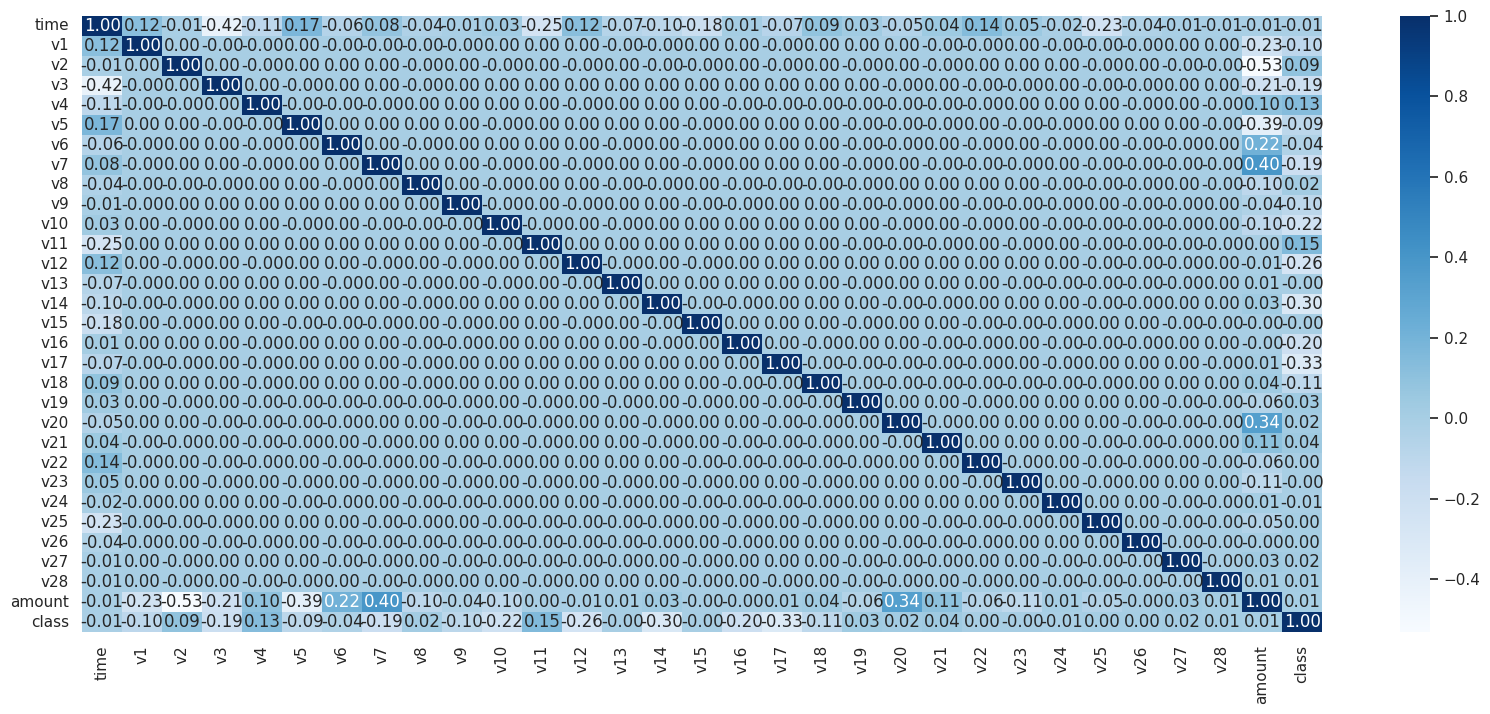

In [12]:
corr = df.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(corr, cmap='Blues', annot=True, fmt='.2f');

No high colinearity between variables.

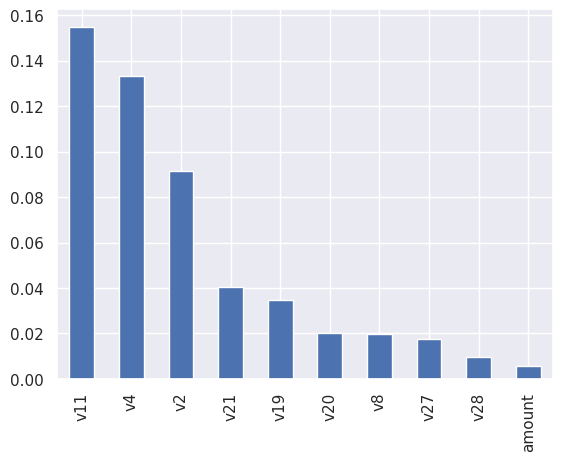

In [13]:
# feature importance based on correlation
corr['class'].sort_values(ascending=False)[1:11].plot(kind='bar');

# Data treatment

In [14]:
# Removing extreme outliers
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (3 * IQR)
upper_bound = Q3 + (3 * IQR)

new_df = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]

In [15]:
# train test split
df_train = df.iloc[:200000]
df_test = df.iloc[200000:]

df_train.shape, df_test.shape

((200000, 31), (84807, 31))

# Treating the problem without considering concept drift

Under and over sampling was used to treat imbalanced data. Time column is not used as it has 0 correlation with class. Models tested:
- Logistic regression
- XGBoost
- Random Forest classifier

In [20]:
# scalers and samplers
scaler = RobustScaler()
tomek = TomekLinks() # tomek links for undersampling
st = SMOTETomek(tomek=tomek)
und = RandomUnderSampler(random_state=101) # same amount for both classes

models = [LogisticRegression(solver='liblinear'), XGBClassifier(), RandomForestClassifier()]

for model in models:
  steps = [
      ('scaler', scaler),
      ('combined', st),
      ('under', und),
      ('model', model)
  ]

  pipe = Pipeline(steps=steps)

  X = df.drop(['time', 'class'], axis=1)
  y = df['class']

  cv = cross_validate(pipe, X, y, cv=3, n_jobs=-1, scoring=['accuracy', 'precision_micro', 'recall_micro', 'f1_micro'])

  print(model)
  print('accuracy:', round(cv['test_accuracy'].mean(), 2))
  print('precision:', round(cv['test_precision_micro'].mean(), 2))
  print('recall:', round(cv['test_recall_micro'].mean(), 2))
  print('f1:', round(cv['test_f1_micro'].mean(), 2))
  print ()

LogisticRegression(solver='liblinear')
accuracy: 0.98


KeyError: 'test_precision'

# Considering Concept Drift

Steps to deal with concept drift in the data:
- Identify concept drift
- build adaptive model
- analyze with specific metrics